In [8]:
import torch.nn.functional as F
from torch import optim
from forestFire import ForestFire
from torch import nn
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

## Setup replay memory object

In [2]:
class ReplayMemory:
    def __init__(self, size):
        self.buffer = []
        self.max_size = size
        self.oldest_transition = 0

    def sample(self, mb):
        return random.sample(self.buffer, mb)

    def new_transition(self, s, a, r, s_p):
        data = [s, a, r, s_p]
        # Check if buffer is full
        if len(self.buffer) == self.max_size:
            # Replace oldest value in the buffer
            self.buffer[self.oldest_transition] = data
            self.oldest_transition += 1
            if self.oldest_transition == self.max_size:
                self.oldest_transition = 0
        else:
            # Append to the end of buffer
            self.buffer.append(data)

# Create Neural Network for DQN

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ForestFireDQN(nn.Module):
    def __init__(self):
        super(ForestFireDQN, self).__init__()
        self.input_layer = nn.Linear(in_features=8, out_features=32)
        self.hidden = nn.Linear(in_features=32, out_features=64)
        self.output_layer = nn.Linear(in_features=64, out_features=4)

    def forward(self, x):
        x.to(device)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden(x))
        x = self.output_layer(x)
        return x

# Add Training For DQN

In [22]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN()
target_policy = ForestFireDQN()
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.SGD(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())

    print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    # End Training

Agent Left
Episode 1 Reward: -100 Steps: 1
Agent Left
Episode 2 Reward: -100 Steps: 1
Agent Left
Episode 3 Reward: -100 Steps: 1
Agent Left
Episode 4 Reward: -100 Steps: 1
Agent Left
Episode 5 Reward: -100 Steps: 2
Person is gone
Agent Left
Episode 6 Reward: -100 Steps: 5
Agent Left
Episode 7 Reward: -100 Steps: 1
Person is gone
Person is gone
Person is gone
Person is gone
Person is gone
Person Found!
Person is gone
Agent in fire
Episode 8 Reward: -10 Steps: 13
Agent Left
Episode 9 Reward: -100 Steps: 1
Agent Left
Episode 10 Reward: -100 Steps: 1
Agent Left
Episode 11 Reward: -100 Steps: 3
Agent Left
Episode 12 Reward: -100 Steps: 1
Person is gone
Agent Left
Episode 13 Reward: -100 Steps: 15
Agent Left
Episode 14 Reward: -100 Steps: 3
Agent Left
Episode 15 Reward: -100 Steps: 1
Agent Left
Episode 16 Reward: -100 Steps: 1
Agent Left
Episode 17 Reward: -100 Steps: 1
Person is gone
Agent in fire
Episode 18 Reward: -10 Steps: 11
Agent Left
Episode 19 Reward: -100 Steps: 1
Agent Left
Episod

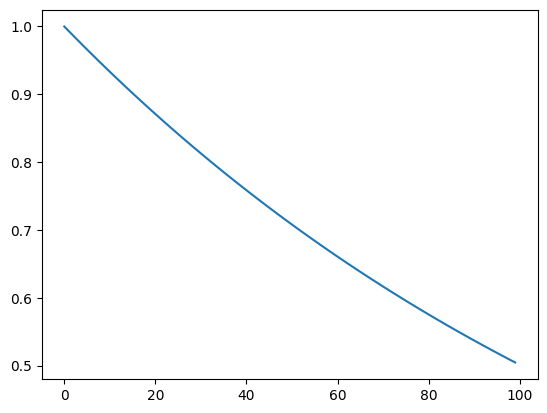

In [9]:
plt.plot(total_epsilons)

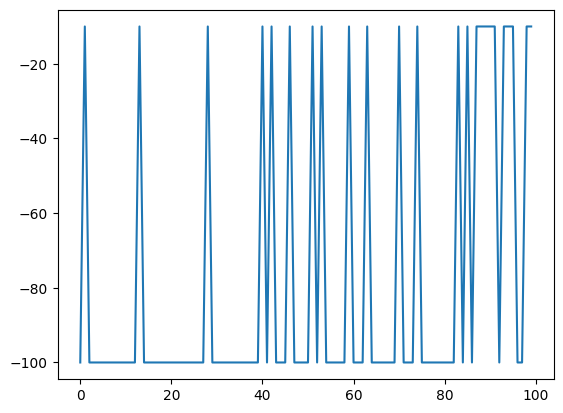

In [10]:
plt.plot(total_rewards)

# Add Training For Double DQN

In [19]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.75

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN()
target_policy = ForestFireDQN()
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.SGD(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(targets_s, estimations_s)
            # loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    # End Training

Agent Left
Episode 1 Reward: -100 Steps: 2
Agent Left
Episode 2 Reward: -100 Steps: 3
Person is gone
Person Found!
Person is gone
Person is gone
Person is gone
Agent in fire
Episode 3 Reward: -10 Steps: 9
Agent Left
Episode 4 Reward: -100 Steps: 1
Agent Left
Episode 5 Reward: -100 Steps: 1
Agent Left
Episode 6 Reward: -100 Steps: 1
Agent Left
Episode 7 Reward: -100 Steps: 2
Agent Left
Episode 8 Reward: -100 Steps: 1
Agent Left
Episode 9 Reward: -100 Steps: 1
Agent Left
Episode 10 Reward: -100 Steps: 5
Person is gone
Person is gone
Person is gone
Person is gone
Agent Left
Episode 11 Reward: -100 Steps: 11
Person is gone
Agent in fire
Episode 12 Reward: -10 Steps: 8
Agent Left
Episode 13 Reward: -100 Steps: 1
Agent Left
Episode 14 Reward: -100 Steps: 4
Agent Left
Episode 15 Reward: -100 Steps: 7
Agent Left
Episode 16 Reward: -100 Steps: 1
Agent Left
Episode 17 Reward: -100 Steps: 9
Agent Left
Episode 18 Reward: -100 Steps: 3
Agent Left
Episode 19 Reward: -100 Steps: 2
Agent Left
Episode 

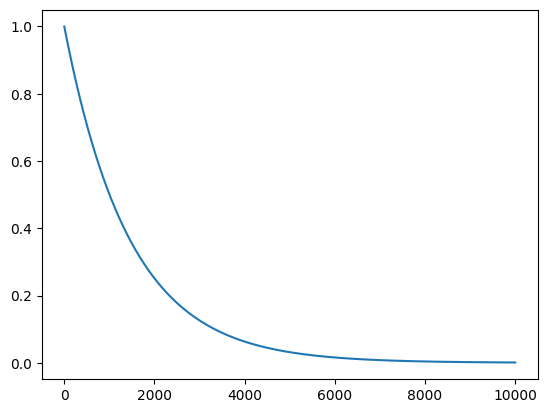

In [20]:
plt.plot(total_epsilons)

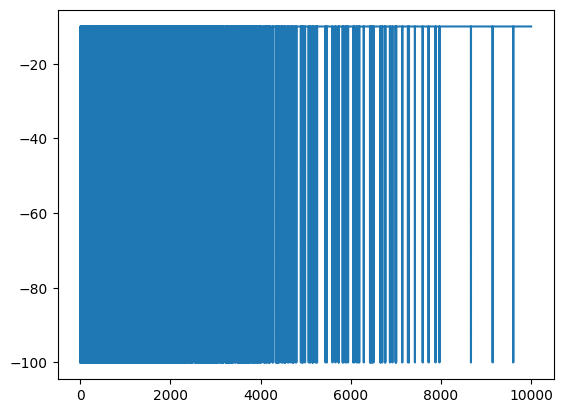

In [21]:
plt.plot(total_rewards)